<a href="https://colab.research.google.com/github/cyamonide/cs445-pix2pixzero/blob/siliu%2Fedit-directions/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/pix2pix-zero

Mounted at /content/drive
/content/drive/MyDrive/pix2pix-zero


In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)
!python --version

2.2.1+cu121
12.1
Python 3.10.12


In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip install tensorflow[and-cuda]
!pip install tensorrt accelerate diffusers==0.12.0 einops gradio ipython numpy opencv-python-headless pillow psutil tqdm transformers
!pip install "jax[cuda12_pip]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install salesforce-lavis

## **Method**
Our project **implements** the core pipeline method in the pix2pix-zero approach, including **inverting real images, discovering edit directions, and editing corss-attention guidance**.

\
In the Pix2Pix-Zero approach, text captions are generated from an input image using BLIP, followed by the creation of an inverse noise map through regularized DDIM inversion. Reference cross-attention maps are then produced to match the structure of the image, guided by the CLIP embeddings of the generated text. The process continues with denoising, using the edited text embeddings, focusing on aligning the current cross-attention maps with the reference ones.
<br>
<br>
<img src="https://pix2pixzero.github.io/assets/method_cat.jpg" width=1500 />
<br>
Figure 1. Pix2Pix-zero pipeline (source: https://pix2pixzero.github.io/)

### **1. Inverting Real Images**
The paper adopts the deterministic DDIM reverse process fro inverting real images into their latent representations. The key steps include:


*   Preparation of the input image and latents
*   Implementation of deterministic DDIM reverse process ([Denoising Diffusion Implicit Models](https://arxiv.org/pdf/2010.02502.pdf))
<br> Inversion entails finding a noise map $x_{inv}$ that reconstructs the input latent code $x_0$ upon sampling. The deterministic DDIM reverse process shows below:
$$ x_{t+1} = \sqrt{\alpha_{t+1}^{-}}f_{\theta}(x_t, t, c) + \sqrt{1-\alpha_{t+1}^{-}}\epsilon_{\theta}(x_t, t, c) $$
where $x_t$ is noised latent code at timestep t, $\epsilon_\theta (x_t , t, c)$ is a UNet-based denoiser that predicts added noise in $x_t$ conditional on timestep t and encoded text features c, $\alpha_{t+1}^{-}$ is noise scaling factor as defined in DDIM, and $f_{\theta}(x_t, t, c)$ predicts the final denoised latent code $x_0$.
$$f_{\theta}(x_t, t, c) = \frac{x_t - \sqrt{1-\alpha_t^{-}}\epsilon_{\theta}(x_t, t, c)}{\sqrt{\alpha_t^{-}}} $$
* Noise regularization
<br> - Auto-correlation regularization $L_{pair}$
$$
L_{pair} = \sum_{p} \frac{1}{S_{p}^{2}} \sum_{\delta=1}^{S_{p}-1} \sum_{x,y,c} \eta^{p}_{x,y,c} (\eta^{p}_{x-\delta,y,c} + \eta^{p}_{x,y-\delta,c}),
$$
<br> - KL Divergence regularization $L_{KL}$
<br> - Final autocorrelation regularization $L_{auto} = L_{pair} + \lambda L_{KL}$
* Image reconstruction





In [ ]:
import sys
import numpy as np
import torch
import torch.nn.functional as F
from random import randrange
from typing import Any, Callable, Dict, List, Optional, Union, Tuple
from diffusers import DDIMScheduler
from diffusers.schedulers.scheduling_ddim import DDIMSchedulerOutput
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from src.utils.base_pipeline import BasePipeline
from src.utils.cross_attention import prep_unet

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

class DDIMInversion(BasePipeline):
  def __call__(
    self,
    prompt: Union[str, List[str]] = None,
    num_inversion_steps: int = 50,
    guidance_scale: float = 7.5,
    negative_prompt: Optional[Union[str, List[str]]] = None,
    num_images_per_prompt: Optional[int] = 1,
    eta: float = 0.0,
    output_type: Optional[str] = "pil",
    return_dict: bool = True,
    cross_attention_kwargs: Optional[Dict[str, Any]] = None,
    img=None,
    torch_dtype=torch.float32,

    # inversion regularization parameters
    lambda_kl: float = 20.0,
    num_reg_steps: int = 5,
    num_ac_rolls: int = 5,
):
    self.unet = prep_unet(self.unet)
    device = self._execution_device
    do_classifier_free_guidance = guidance_scale > 1.0

    # Prepare the input image and encode to latent space
    x0 = self.prep_img(img, device, torch_dtype)
    x0_enc = self.encode_latents(x0, device, torch_dtype)

    # Decode
    with torch.no_grad():
      x0_dec = self.decode_latents(x0_enc.detach())
    image_x0_dec = self.numpy_to_pil(x0_dec)

    # DDIM inversion
    prompt_embeds = self._encode_prompt(prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt).to(device)
    extra_step_kwargs = self.prepare_extra_step_kwargs(None, eta)

    latents = x0_enc
    latents = self.perform_inversion(x0_enc, num_inversion_steps, device, torch_dtype, prompt_embeds, extra_step_kwargs, \
    do_classifier_free_guidance, cross_attention_kwargs, guidance_scale, num_reg_steps, lambda_kl, num_ac_rolls, latents)

    x_inv = latents.detach().clone()

    # Decode the latent back to image space
    img = self.decode_latents(latents.detach())
    img = self.numpy_to_pil(img)

    return x_inv, img, image_x0_dec

  # prepare the input image
  def prep_img (self, img, device, torch_dtype):
    x0 = np.array(img) / 255
    x0 = torch.from_numpy(x0).type(torch_dtype).permute(2, 0, 1).unsqueeze(0).repeat(1, 1, 1, 1).to(device)
    return (x0 - 0.5) * 2

  # encode to latent space
  def encode_latents(self, x0, device, torch_dtype):
    with torch.no_grad():
      # vae: AutoencoderKL
      x0_enc = self.vae.encode(x0).latent_dist.sample().to(device, torch_dtype)
    # normalization
    return 0.18215 * x0_enc

  # perform the DDIM inversion
  def perform_inversion(self, x0_enc, num_inversion_steps, device, torch_dtype, prompt_embeds, \
  extra_step_kwargs, do_classifier_free_guidance, cross_attention_kwargs, guidance_scale, \
  num_reg_steps, lambda_kl, num_ac_rolls, latents):
    # set timesteps
    self.scheduler.set_timesteps(num_inversion_steps, device=device)
    timesteps = self.scheduler.timesteps

    num_warmup_steps = len(timesteps) - num_inversion_steps * self.scheduler.order
    with self.progress_bar(total=num_inversion_steps) as progress_bar:
      for i, t in enumerate(timesteps.flip(0)[1:-1]):
        # implementation of classifier-free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents

        # alpha_t: adjusts the input latents according to a noise schedule
        latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

        # e_t: a U-Net model (f_theta) predicts the noise for the given timesteps
        with torch.no_grad():
            noise_pred = self.unet(latent_model_input,t,encoder_hidden_states=prompt_embeds,cross_attention_kwargs=cross_attention_kwargs,).sample
        # print(f"noise_pred before regularization: {noise_pred} \n")

        noise_pred = self.apply_regularization(noise_pred, lambda_kl, do_classifier_free_guidance, \
        guidance_scale, num_reg_steps, num_ac_rolls)
        # print(f"noise_pred after regularization: {noise_pred} \n")

        # x_t steps back towards x_{t-1}: updates the latents by removing the noise epsilon_{\theta}
        latents = self.scheduler.step(noise_pred, t, latents, reverse=True, **extra_step_kwargs).prev_sample

        # callback
        if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
            progress_bar.update()

    return latents

  # apply auto-correclation and KL divergence regularization
  def apply_regularization(self, noise_pred, lambda_kl, do_classifier_free_guidance, guidance_scale, num_reg_steps, num_ac_rolls):
    # perform guidance
    if do_classifier_free_guidance:
        # split the noise predcition tensor into two parts: one unconditioned and one conditioned on text
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # regularization of the noise prediction
    e_t = noise_pred
    for _ in range(num_reg_steps):
      e_t = self.regularize_noise(e_t,lambda_kl, num_ac_rolls)
    return e_t

  def regularize_noise(self, e_t, lambda_kl, num_ac_rolls):
    for _ in range(num_ac_rolls):
      e_t = self.apply_auto_corr_loss(e_t)
      if lambda_kl > 0:
          e_t = self.apply_kl_divergence_loss(e_t, lambda_kl)
    return e_t

  def apply_auto_corr_loss(self, e_t):
    e_t.requires_grad_(True)
    # use SGD optimizer
    optimizer = torch.optim.SGD([e_t], lr=0.1)
    optimizer.zero_grad()
    # calculate the auto_corr_loss
    l_ac = self.auto_corr_loss(e_t)
    # calculate gradients
    l_ac.backward()
    optimizer.step()
    e_t.detach_()

    return e_t

  # L_pair
  def auto_corr_loss(self, x, random_shift=True):
    B, C, H, W = x.shape
    assert B == 1
    # [C, H, W]
    x = x.squeeze(0)

    reg_loss = 0.0
    for channel in x:
      # [1, 1, H, W]
      noise = channel.unsqueeze(0).unsqueeze(0)
      # H == W
      current_size = noise.size(2)

      while current_size >= 8:
        if random_shift and current_size > 1:
          roll_amount_h = randrange(current_size // 2)
          roll_amount_w = randrange(current_size // 2)
        else:
          roll_amount_h, roll_amount_w = 1, 1

        # Compute autocorrelation for shifted tensors in both dimensions
        rolled_h = torch.roll(noise, shifts=roll_amount_h, dims=2)
        rolled_w = torch.roll(noise, shifts=roll_amount_w, dims=3)
        reg_loss += (noise * rolled_h).mean().pow(2)
        reg_loss += (noise * rolled_w).mean().pow(2)

        # Reduce size by pooling
        noise = F.avg_pool2d(noise, kernel_size=2)
        current_size = noise.size(2)

    return reg_loss

  def apply_kl_divergence_loss(self, e_t, lambda_kl):
    var = e_t.detach().clone().requires_grad_(True)
    # compute the auto_corr_loss
    l_kld = self.kl_divergence(var)
    # compute the gradients and store the gradients in var.grad
    l_kld.backward()
    grad = var.grad.detach()
    return e_t - lambda_kl * grad

  # calculate the KL divergence for regularization
  def kl_divergence(self, x):
    _mu = x.mean()
    _var = x.var()

    # KL divergence for Gaussian distribution with mean=0 and variance=1
    return _var + _mu**2 - 1 - torch.log(_var + 1e-7)

### **2. Discovering Edit Directions**

In [ ]:
import re
from transformers import T5Tokenizer, T5ForConditionalGeneration

"""
Remove any undesirable characters that might affect edit direction generation.
"""
def clean_sentences(sentences):
  characters_to_remove = "012345679.,'-():!"
  cleaned_sentences = sentences

  for c in characters_to_remove:
    cleaned_sentences = [s.replace(c, "") for s in cleaned_sentences]

  cleaned_sentences = [s.strip().lower() for s in cleaned_sentences]

  return cleaned_sentences

"""
Use Google's Flan T5 XL model to generate :num: sentences containing a
particular word. By default, 1024 sentences are generated since ~1000 is
recommended for reasonable results:
https://github.com/pix2pixzero/pix2pix-zero/issues/16#issuecomment-1485394203
"""
def compute_sentences(word, count=1024):
  model_name = "google/flan-t5-xl"
  prompt = f"Provide a caption for images containing {word}. The captions should be in English and be shorter than 150 characters. The caption must contain the word {word}."

  tokenizer = T5Tokenizer.from_pretrained(model_name)
  model = T5ForConditionalGeneration.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16)

  prompt_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
  prompt_length = prompt_ids.shape[1]

  sentences = []

  while len(sentences) < count:
    try:
      output_ids = model.generate(
          prompt_ids,
          do_sample=True,
          num_return_sequences=8,
          max_length=128,
          min_length=15
      )
      output = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    except:
      continue

    sentences += output

    print(f"{len(sentences)}/{count} generated.")

  # clean
  sentences = clean_sentences(sentences)

  del model
  del tokenizer
  torch.cuda.empty_cache()

  return sentences

In [ ]:
word = "horse"
sentences = compute_sentences(word, 1024)

In [ ]:
with open(f"sentences/{word}.txt", 'w') as f:
  for s in sentences:
    f.write(f"{s}\n")

In [ ]:
import os
from transformers import CLIPTokenizer, CLIPTextModel
from src.utils.edit_pipeline import EditingPipeline

def get_edit_direction(task_name):
  task_from = task_name.split('2')[0]
  task_to = task_name.split('2')[1]

  model_name = "CompVis/stable-diffusion-v1-4"

  pipe = EditingPipeline.from_pretrained(model_name, torch_dtype=torch.float16).to(device)

  tokenizer = pipe.tokenizer
  encoder = pipe.text_encoder

  # tokenizer = CLIPTokenizer.from_pretrained(model_name)
  # encoder = CLIPTextModel.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16)

  # Create embeddings
  for thing in task_name.split('2'):
    sentence_filepath = f"sentences/{thing}.txt"
    embedding_filepath = f"assets/embeddings_sd_1.4/{thing}.pt"

    # Skip embedding generation if it already exists
    if os.path.exists(embedding_filepath):
      print(f"{embedding_filepath} already exists, skipping generation!")
      continue

    with open(sentence_filepath, 'r') as f:
      sentences = [l.strip() for l in f.readlines()]

    sentence_embeddings = []

    with torch.no_grad():
      for s in sentences:
        sentence_t = tokenizer(
            s,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        )
        sentence_ids = sentence_t.input_ids
        embeds = encoder(sentence_ids.to(device), attention_mask=None)[0]
        sentence_embeddings.append(embeds)

        # memory mgmt
        del sentence_ids

      average_embeddings = torch.concatenate(sentence_embeddings, dim=0).mean(dim=0).unsqueeze(0)

      print(f"Saving embeddings file {embedding_filepath}...")
      torch.save(average_embeddings, embedding_filepath)

  del tokenizer
  del encoder
  del pipe

  # Compute difference between embeddings
  from_embeddings = torch.load(f"assets/embeddings_sd_1.4/{task_from}.pt", map_location=device)
  to_embeddings = torch.load(f"assets/embeddings_sd_1.4/{task_to}.pt", map_location=device)

  difference = (to_embeddings.mean(0) - from_embeddings.mean(0)).unsqueeze(0)

  return difference

In [ ]:
get_edit_direction("car2horse")

In [ ]:
! python src/edit_synthetic.py \
    --results_folder "output/synth_editing_car" \
    --prompt_str "a high resolution photo of the side of a car" \
    --task "car2horse"\
    --use_float_16

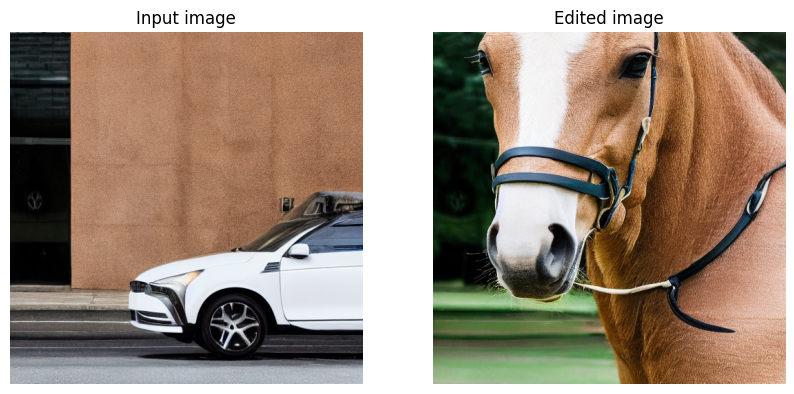

In [ ]:
input_path = f"output/synth_editing_car/reconstruction.png"
edit_path = f"output/synth_editing_car/edit.png"

input_img = cv2.cvtColor(cv2.imread(input_path), cv2.COLOR_BGR2RGB)
edit_img = cv2.cvtColor(cv2.imread(edit_path), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_img)
plt.title('Input image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edit_img)
plt.title('Edited image')
plt.axis('off')
plt.show()

In [ ]:
! python src/make_edit_direction.py \
        --file_source_sentences sentences/pineapple.txt \
        --file_target_sentences sentences/strawberry.txt \
        --output_folder assets/embeddings_sd_1.4

In [ ]:
! python src/inversion.py  \
        --input_image "assets/test_images/pineapples/pineapple_1.jpg" \
        --results_folder "output/test_pineapple_3"

In [ ]:
! python src/edit_real.py \
    --inversion "output/test_pineapple_3/inversion/pineapple_1.pt" \
    --prompt "output/test_pineapple_3/prompt/pineapple_1.txt" \
    --task_name "pineapple2strawberry" \
    --results_folder "output/test_pineapple_3/"\
    --use_float_16 \
    --edit_direction_multiplier 5

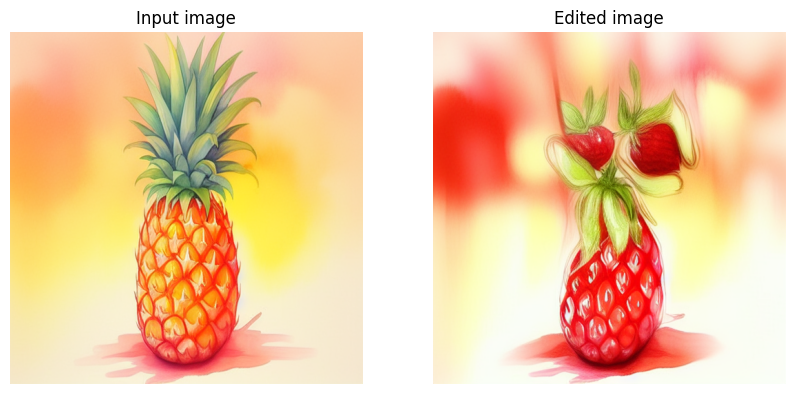

In [ ]:
input_path = f"output/test_pineapple_3/reconstruction/pineapple_1.png"
edit_path = f"output/test_pineapple_3/edit/pineapple_1_strawberry_2.png"

input_img = cv2.cvtColor(cv2.imread(input_path), cv2.COLOR_BGR2RGB)
edit_img = cv2.cvtColor(cv2.imread(edit_path), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_img)
plt.title('Input image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edit_img)
plt.title('Edited image')
plt.axis('off')
plt.show()

### **3. Editing via Cross-Attention Guidance**

In [ ]:
import torch
import torch.nn.functional as F

class Pix2PixZero:
    def __init__(self, model, text_encoder, edit_direction, cross_attention_weight):
        self.model = model
        self.text_encoder = text_encoder
        self.edit_direction = edit_direction
        self.cross_attention_weight = cross_attention_weight

    def compute_reference_attention_maps(self, x, c):
        reference_maps = []
        for t in reversed(range(len(x))):
            _, M_ref_t = self.model(x[t], t, c)
            reference_maps.insert(0, M_ref_t)
        return reference_maps

    def edit_with_cross_attention_guidance(self, x, c):
        edit_direction = self.edit_direction
        cross_attention_weight = self.cross_attention_weight

        c_edit = c + edit_direction

        reference_maps = self.compute_reference_attention_maps(x, c)

        for t in reversed(range(len(x))):
            _, M_edit_t = self.model(x[t], t, c_edit)
            cross_attention_loss = F.mse_loss(M_edit_t, reference_maps[t])
            x_grad = torch.autograd.grad(cross_attention_loss, x[t], retain_graph=True)[0]
            x_grad *= cross_attention_weight
            x[t] = self.update_state(x[t], x_grad)

        return x

    def update_state(self, x, x_grad):
        alpha = 0.99
        x_pred = self.model(x)
        updated_state = torch.sqrt(alpha) * x + torch.sqrt(1 - alpha) * x_pred + torch.sqrt(1 - alpha) * x_grad
        return updated_state

### **4. Quantitative Evaluations**
For quantitative evaluations, we use three metrics.
*   **CLIP Acc:** measuring whether the edit is applied successfully by assessing alignment with target attributes. (Hessel, Jack, et al. [CLIPScore](https://aclanthology.org/2021.emnlp-main.595v2.pdf))
*   **Structure Dist:**  measuring whether the structure of the input and edited image is consistent (Tumanyan, Narek, et al. [Splicing ViT](https://openaccess.thecvf.com/content/CVPR2022/papers/Tumanyan_Splicing_ViT_Features_for_Semantic_Appearance_Transfer_CVPR_2022_paper.pdf)).
*   **LPIPS error:** measuring perceptual similarity between images by utilizing deep learning features from AlexNet and VGG (Zhang, Richard, et al. [PerceptualSimilarity](https://arxiv.org/pdf/1801.03924)).




**1. CLIP Acc**\
We **use** the official code for the EMNLP 2021 paper: "CLIPScore: A Reference-free Evaluation Metric for Image Captioning" to evaluate the CLIPScore.

In [ ]:
%cd '/content/drive/MyDrive'
!git clone https://github.com/jmhessel/clipscore.git

!pip install git+https://github.com/openai/CLIP.git
!pip install git+https://github.com/jmhessel/pycocoevalcap.git

%cd clipscore

In [ ]:
import subprocess
import warnings
warnings.filterwarnings('ignore')

operations = [
    ("SDEdit with word swap", "../scoreTest/captionA.json", "../scoreTest/images/img_1"),
    ("prompt-to-prompt", "../scoreTest/captionB.json", "../scoreTest/images/img_2"),
    ("DDIM with word swap", "../scoreTest/captionC.json", "../scoreTest/images/img_3"),
    ("Pix2pix-zero", "../scoreTest/captionD.json", "../scoreTest/images/img_4")
]

for title, caption_path, image_path in operations:
    result = subprocess.run(['python', 'clipscore.py', caption_path, image_path], text=True, capture_output=True)
    lines = result.stdout.split('\n')
    clipscore = next((line.strip() for line in lines if "CLIPScore:" in line), "CLIPScore not found")

    print(f'{title} CLIPScore: {clipscore.split(":")[1].strip()}')


SDEdit with word swap CLIPScore: 0.7609
prompt-to-prompt CLIPScore: 0.6946
DDIM with word swap CLIPScore: 0.7612
Pix2pix-zero CLIPScore: 0.7755


Notes: to run the above code, the input files are formatted as follows:
*   The candidates json should be a dictionary that maps from {"string_image_identifier": "candidate"}, e.g., {"imgA_1": "add glasses to a cat.", "imgB_1": "cat2Dog", "imgC_1": "horse2Zebra"}.
*   The image directory should be a directory containing the images that act as the keys in the candidates json.


**2. Structure Dist**
\
We **implement** the method described in the CVPR 2022 paper "Splicing ViT Features for Semantic Appearance Transfer" for measuring strucutural distance between two images using a pre-trained Vision Transformer (ViT) model.
\
$$ L_{structure} = \left\| S^{L}(I_s) - S^{L}(I_o) \right\|_F $$
\
The term $L_{structure}$ measures if the output image matches the structure of $I_s$, and is defined by the difference in self-similarity of the keys extracted from the attention module at deepest transformer layer, where $S^{L}(I_s)$ is defined as:
$$S^{L}(I)_{ij} = \text{cos-sim} \left( k^{L}_{i}(I), k^{L}_{j}(I) \right) $$
\
It leverages deep spatial features extracted from DINO-ViT, and use their self-similarity as structure representation. cos-sim is the cosine similarity between keys.

In [ ]:
import torch
from torch import nn
import cv2
from transformers import ViTModel, ViTFeatureExtractor
from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

"""
Load DINO-Vit(self-distillation with no labels) self-supervised vision transformer
repo: https://github.com/facebookresearch/dino
"""
def load_pretrained_vit(model_name='facebook/dino-vitb8'):
    feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
    model = ViTModel.from_pretrained(model_name)
    model.eval()

    return feature_extractor, model

# Preprocess an image
def preprocess_image(image_path, feature_extractor):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs['pixel_values']

# Compute the self-similarity matrix
def compute_self_similarity(keys):
    keys_norm = torch.nn.functional.normalize(keys, p=2, dim=-1)
    cosine_similarity = torch.matmul(keys_norm, keys_norm.transpose(-2, -1))

    return cosine_similarity

# Calculate the structural distance
def calculate_structure_distance(ss_matrix1, ss_matrix2):
    return torch.norm(ss_matrix1 - ss_matrix2, p='fro').item()

# Load model and feature extractor
feature_extractor, vit_model = load_pretrained_vit()

**3. LPIPS error**
\
We **use** the official code for the CVPR 2018 paper "The Unreasonable Effectiveness of Deep Features as a Perceptual Metric" for measuring LPIPS error. Compared to traditional metrics like PSNR and SSIM, it explores the utility of deep learning features from networks AlexNet and VGG in measurign perceptual similarity between images.

\
<img src="https://richzhang.github.io/PerceptualSimilarity/index_files/network.jpg" width=800 />
\
Figure 2. LPIP metric pipeline (source: https://richzhang.github.io/PerceptualSimilarity/)

In [ ]:
!pip install lpips

In [ ]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 61.6MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 77.5MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


**4. Evaluation**
\
Here we compare pix2pix-zero approach to some previous and concurrent diffusion-based image eidting methods. The baseline models include **SDEdit+word swap, Prompt-to-Prompt, and DDIM+word swap**. The output images of the baselines are from the paper.

\
The metrics effectively demonstrate that Pix2Pix-zero approach gets **a high CLIP-Acc while having low Structure Dist and LPIPS error**, showing this approach have good edit performance while still retaining the image structure.

In [ ]:
%cd /content/drive/MyDrive/metricTest/

imgA group comparison: 

ViT Structural Distance for SDEdit with word swap: 36.57640838623047
ViT Structural Distance for prompt-to-prompt: 42.204769134521484
ViT Structural Distance for DDIM with word swap: 37.600929260253906
ViT Structural Distance for Pix2pix-zero: 20.239362716674805


LPIPS Distance (net='alex') for SDEdit with word swap: 0.44610685110092163
LPIPS Distance (net='alex') for prompt-to-prompt: 0.42155736684799194
LPIPS Distance (net='alex') for DDIM with word swap: 0.433724582195282
LPIPS Distance (net='alex') for Pix2pix-zero: 0.13311536610126495


LPIPS Distance (net='vgg') for SDEdit with word swap: 0.45511505007743835
LPIPS Distance (net='vgg') for prompt-to-prompt: 0.3899023234844208
LPIPS Distance (net='vgg') for DDIM with word swap: 0.4161480665206909
LPIPS Distance (net='vgg') for Pix2pix-zero: 0.1706002950668335


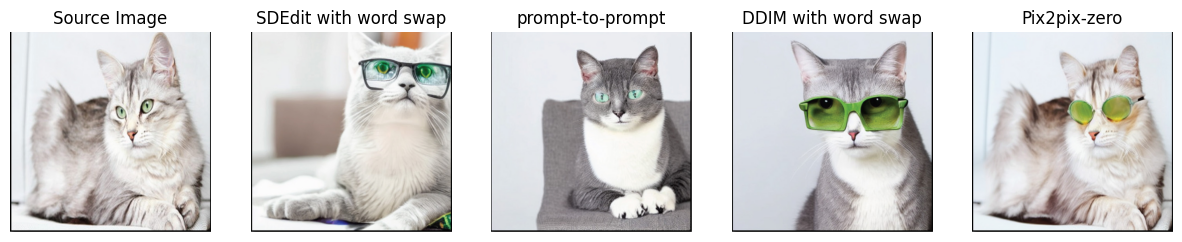

imgB group comparison: 

ViT Structural Distance for SDEdit with word swap: 38.53124237060547
ViT Structural Distance for prompt-to-prompt: 10.37633228302002
ViT Structural Distance for DDIM with word swap: 29.713180541992188
ViT Structural Distance for Pix2pix-zero: 20.3143367767334


LPIPS Distance (net='alex') for SDEdit with word swap: 0.5953417420387268
LPIPS Distance (net='alex') for prompt-to-prompt: 0.040488146245479584
LPIPS Distance (net='alex') for DDIM with word swap: 0.23440121114253998
LPIPS Distance (net='alex') for Pix2pix-zero: 0.1020553782582283


LPIPS Distance (net='vgg') for SDEdit with word swap: 0.5789598226547241
LPIPS Distance (net='vgg') for prompt-to-prompt: 0.0745190903544426
LPIPS Distance (net='vgg') for DDIM with word swap: 0.31518805027008057
LPIPS Distance (net='vgg') for Pix2pix-zero: 0.23472380638122559


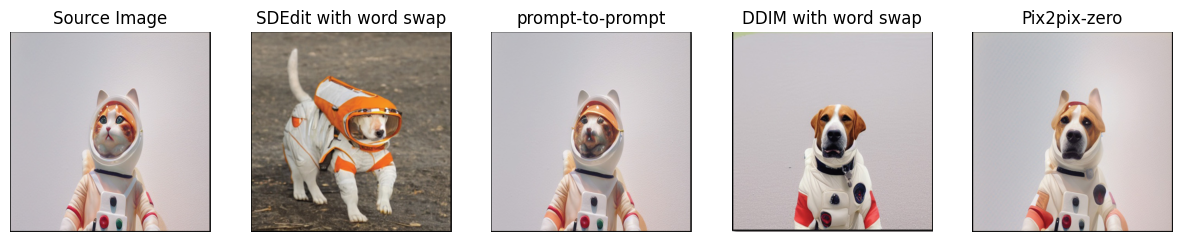

imgC group comparison: 

ViT Structural Distance for SDEdit with word swap: 39.377803802490234
ViT Structural Distance for prompt-to-prompt: 26.973648071289062
ViT Structural Distance for DDIM with word swap: 38.85601806640625
ViT Structural Distance for Pix2pix-zero: 36.88230514526367


LPIPS Distance (net='alex') for SDEdit with word swap: 0.5509482622146606
LPIPS Distance (net='alex') for prompt-to-prompt: 0.17109443247318268
LPIPS Distance (net='alex') for DDIM with word swap: 0.5545986890792847
LPIPS Distance (net='alex') for Pix2pix-zero: 0.30605173110961914


LPIPS Distance (net='vgg') for SDEdit with word swap: 0.5988897085189819
LPIPS Distance (net='vgg') for prompt-to-prompt: 0.2757321000099182
LPIPS Distance (net='vgg') for DDIM with word swap: 0.5649929642677307
LPIPS Distance (net='vgg') for Pix2pix-zero: 0.3490219712257385


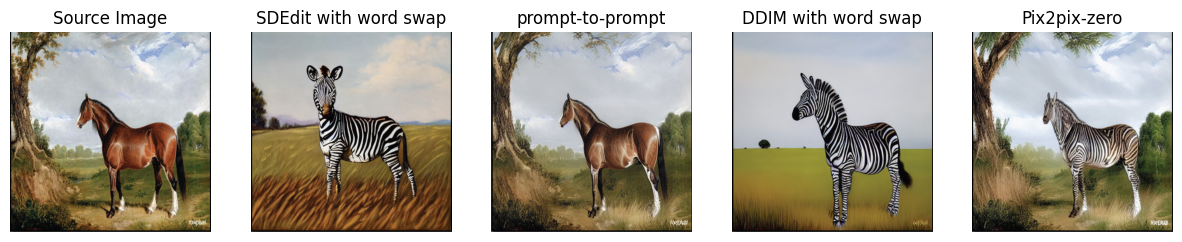

In [ ]:
source_image_paths = ['./imgA_0.png', './imgB_0.png', './imgC_0.png']
output_suffixes = ['_1.png', '_2.png', '_3.png', '_4.png']
titles = ['SDEdit with word swap', 'prompt-to-prompt', 'DDIM with word swap', 'Pix2pix-zero']

for source_image_path in source_image_paths:
    source_inputs = preprocess_image(source_image_path, feature_extractor)
    with torch.no_grad():
        source_outputs = vit_model(source_inputs, output_attentions=True)
        source_keys = source_outputs.attentions[-1].mean(dim=1)
        source_ss = compute_self_similarity(source_keys)

    source_img = cv2.cvtColor(cv2.imread(source_image_path), cv2.COLOR_BGR2RGB).astype('float32') / 255.0
    source_img_tensor = torch.tensor(source_img).permute(2, 0, 1).unsqueeze(0)

    base_name = source_image_path.split('/')[-1].split('_')[0]
    output_image_paths = [f"{base_name}{suffix}" for suffix in output_suffixes]
    output_imgs = []
    output_imgs = []

    print(f"{base_name} group comparison: \n")
    for index, output_image_path in enumerate(output_image_paths):

        output_img = cv2.cvtColor(cv2.imread(output_image_path), cv2.COLOR_BGR2RGB).astype('float32') / 255.0

        # ViT structural distance
        output_inputs = preprocess_image(output_image_path, feature_extractor)
        with torch.no_grad():
            output_outputs = vit_model(output_inputs, output_attentions=True)
            output_keys = output_outputs.attentions[-1].mean(dim=1)
            output_ss = compute_self_similarity(output_keys)
            vit_distance = calculate_structure_distance(source_ss, output_ss)

        print(f"ViT Structural Distance for {titles[index]}: {vit_distance}")
        output_imgs.append(output_img)

    print("\n")
    for index, output_image_path in enumerate(output_image_paths):
        output_img = cv2.cvtColor(cv2.imread(output_image_path), cv2.COLOR_BGR2RGB).astype('float32') / 255.0
        output_img_tensor = torch.tensor(output_img).permute(2, 0, 1).unsqueeze(0)

        # LPIPS distance_alex
        lpips_distance_alex = loss_fn_alex(source_img_tensor, output_img_tensor).item()
        print(f"LPIPS Distance (net='alex') for {titles[index]}: {lpips_distance_alex}")

    print("\n")
    for index, output_image_path in enumerate(output_image_paths):
        output_img = cv2.cvtColor(cv2.imread(output_image_path), cv2.COLOR_BGR2RGB).astype('float32') / 255.0
        output_img_tensor = torch.tensor(output_img).permute(2, 0, 1).unsqueeze(0)

        # LPIPS distance_vgg
        lpips_distance_vgg = loss_fn_vgg(source_img_tensor, output_img_tensor).item()
        print(f"LPIPS Distance (net='vgg') for {titles[index]}: {lpips_distance_vgg}")

    num_images = len(output_imgs) + 1
    plt.figure(figsize=(15, num_images * 5))
    plt.subplot(1, num_images, 1)
    plt.imshow(source_img)
    plt.title('Source Image')
    plt.axis('off')

    for idx, (img, title) in enumerate(zip(output_imgs, titles), start=2):
        plt.subplot(1, num_images, idx)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')

    plt.show()

**5. Image detection**
\
We **use** the Detic model implemented in the paper "Detecting Twenty-thousand Classes using Image-level Supervision" (Zhou, Xingyi et al. [Detic](https://arxiv.org/pdf/2201.02605)) for identifying different regions of the original and edited images.

In [ ]:
# environment setup
%cd /content/drive/MyDrive
!git clone https://github.com/facebookresearch/detectron2.git
%cd detectron2
!pip install -e .

In [ ]:
%cd /content/drive/MyDrive
!git clone https://github.com/facebookresearch/Detic.git --recurse-submodules
%cd Detic
!pip install -r requirements.txt
%cd third_party
!git clone https://github.com/xingyizhou/CenterNet2.git
!git clone https://github.com/fundamentalvision/Deformable-DETR.git

In [ ]:
# get Detic model
%cd /content/drive/MyDrive/Detic
%mkdir models
!wget https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth -O models/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth

In [ ]:
%cd /content/drive/MyDrive/Detic

In [ ]:
# run the model
!python demo.py --config-file configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml --input ./models/cat_7.png --output ./models/output_0.png --vocabulary lvis --opts MODEL.WEIGHTS models/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth
!python demo.py --config-file configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml --input ./models/cat_7_output.png --output ./models/output_1.png --vocabulary lvis --opts MODEL.WEIGHTS models/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth

[05/05 15:53:52 detectron2]: Arguments: Namespace(config_file='configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml', webcam=None, cpu=False, video_input=None, input=['./models/cat_7.png'], output='./models/output_0.png', vocabulary='lvis', custom_vocabulary='', pred_all_class=False, confidence_threshold=0.5, opts=['MODEL.WEIGHTS', 'models/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth'])
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[05/05 15:54:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from models/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth ...
[05/05 15:54:06 fvcore.common.checkpoint]: [Checkpointer] Loading from models/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_m

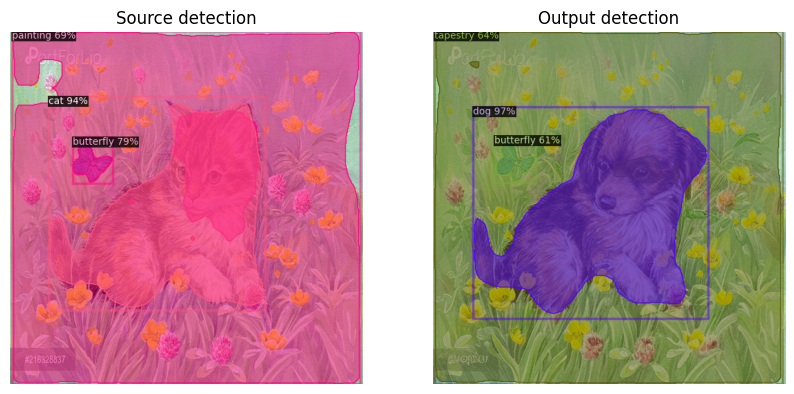

In [ ]:
# Show Detic output
import cv2
import matplotlib.pyplot as plt

source_detic = './models/output_0.png'
output_detic = './models/output_1.png'

source_detection = cv2.cvtColor(cv2.imread(source_detic), cv2.COLOR_BGR2RGB).astype('double') / 255.0
output_detection = cv2.cvtColor(cv2.imread(output_detic), cv2.COLOR_BGR2RGB).astype('double') / 255.0

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(source_detection)
plt.title('Source detection')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_detection)
plt.title('Output detection')
plt.axis('off')
plt.show()

### 5. Automatic image rotation

In [ ]:
def rotate_image(image, degrees):
  h,w = image.shape[:2]
  T = cv2.getRotationMatrix2D((w/2, h/2), degrees, 1)
  return cv2.warpAffine(image, T, (w,h))

In [ ]:
# Generate rotated images
original_image = cv2.imread('assets/test_images/cats/cat_7.png')

for angle in range(0, 360, 30):
  cv2.imwrite(f'assets/test_images/cats/cat_7_{angle}.jpg', rotate_image(original_image, angle))

In [ ]:
%cd /content/drive/MyDrive/pix2pix-zero/

import os
import subprocess
import cv2
import matplotlib.pyplot as plt

def edit_real(input_image_id, results_folder, task):
  input_image = f"assets/test_images/cats/{input_image_id}.jpg"

  cmd = [
    "python", "src/inversion.py",
    "--input_image", input_image,
    "--results_folder", results_folder
  ]
  print(" ".join(cmd))
  res = subprocess.run(cmd, capture_output = True, text = True)

  cmd = [
      "python",
      "src/edit_real.py",
      "--inversion", f"{results_folder}/inversion/{input_image_id}.pt",
      "--prompt", f"{results_folder}/prompt/{input_image_id}.txt",
      "--task_name", task,
      "--results_folder", results_folder,
      "--use_float_16"
  ]
  print(" ".join(cmd))
  res = subprocess.run(cmd, capture_output=True, text=True)

  input_img = cv2.cvtColor(cv2.imread(input_image), cv2.COLOR_BGR2RGB).astype('double') / 255.0
  edited_img = cv2.cvtColor(cv2.imread(f"{results_folder}/edit/{input_image_id}.png"), cv2.COLOR_BGR2RGB).astype('double') / 255.0

  return (input_img, edited_img)

In [ ]:
# Edit rotated images

task = "cat2dog"

for angle in range(0, 360, 30):
  input_image_id = f"cat_7_{angle}"
  results_folder = f"output/test_cat_{angle}"

  input_img, edited_img = edit_real(input_image_id, results_folder, task)

In [ ]:
%cd /content/drive/MyDrive/Detic

import subprocess
import pickle

# Grade all images for target object

scores = {}
target_object = "dog"

for angle in range(0, 360, 30):
  cmd = [
        "python", "demo.py",
        "--config-file", "configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml",
        "--input", f"../pix2pix-zero/output/test_cat_{angle}/edit/cat_7_{angle}.png",
        "--output", f"./models/output_{angle}.png",
        "--vocabulary", "lvis",
        "--opts", "MODEL.WEIGHTS", "models/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth"
    ]
  print(" ".join(cmd))
  res = subprocess.run(cmd, capture_output=True, text=True)

  print(res.stderr)

  labels_l = pickle.load(open('./models/labels', 'rb'))
  labels_l = [(" ".join(l.split()[:-1]), int(l.split()[-1][:-1])) for l in labels_l]
  labels = {}
  for p in labels_l:
    labels[p[0]] = p[1]

  if target_object in labels:
    scores[angle] = labels[target_object]
  else:
    scores[angle] = 0

print(scores)

python demo.py --config-file configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml --input ../pix2pix-zero/output/test_cat_0/edit/cat_7_0.png --output ./models/output_0.png --vocabulary lvis --opts MODEL.WEIGHTS models/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

100%|██████████| 1/1 [00:02<00:00,  2.63s/it]

python demo.py --config-file configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml --input ../pix2pix-zero/output/test_cat_30/edit/cat_7_30.png --output ./models/output_30.png --vocabulary lvis --opts MODEL.WEIGHTS models/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: User

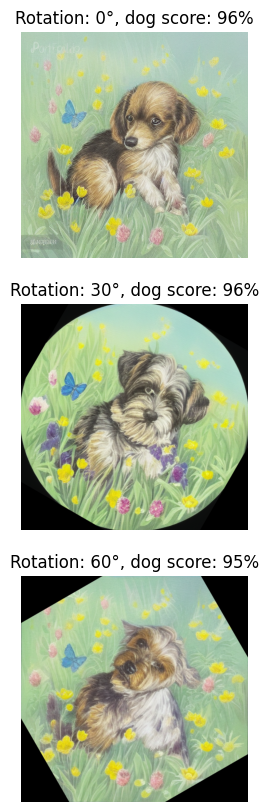

In [ ]:
import cv2
import matplotlib.pyplot as plt

images = {}

for angle in range(0, 360, 30):
  img_path = f"../pix2pix-zero/output/test_cat_{angle}/edit/cat_7_{angle}.png"
  edited_image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB).astype('double') / 255.0
  images[angle] = edited_image

# get top 3 scores
best_scores = sorted(scores.items(), key=lambda item: item[0])[:3]

plt.figure(figsize=(10, 10))

for i, p in enumerate(best_scores):
  # Read image
  angle, score = p
  img_path = f"../pix2pix-zero/output/test_cat_{angle}/edit/cat_7_{angle}.png"
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB).astype('double') / 255.0
  # Rotate image back
  img = rotate_image(img, -angle)

  # Plot image
  plt.subplot(3, 1, i+1)
  plt.imshow(img)
  plt.title(f"Rotation: {angle}°, {target_object} score: {score}%")
  plt.axis('off')

plt.show()


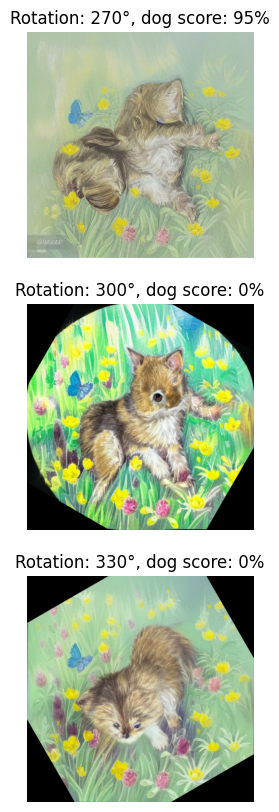

In [ ]:
# For completeness, get bottom 3 scores
best_scores = sorted(scores.items(), key=lambda item: item[0])[-3:]

plt.figure(figsize=(10, 10))

for i, p in enumerate(best_scores):
  # Read image
  angle, score = p
  img_path = f"../pix2pix-zero/output/test_cat_{angle}/edit/cat_7_{angle}.png"
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB).astype('double') / 255.0
  # Rotate image back
  img = rotate_image(img, -angle)

  # Plot image
  plt.subplot(3, 1, i+1)
  plt.imshow(img)
  plt.title(f"Rotation: {angle}°, {target_object} score: {score}%")
  plt.axis('off')

plt.show()

## **Running the code**

In [ ]:
! python src/inversion.py  \
        --input_image "assets/test_images/cats/cat_7.png" \
        --results_folder "output/test_cat"

In [ ]:
! python src/edit_real.py \
    --inversion "output/test_cat/inversion/cat_7.pt" \
    --prompt "output/test_cat/prompt/cat_7.txt" \
    --task_name "cat2dog" \
    --results_folder "output/test_cat/"\
    --use_float_16

In [ ]:
! python src/edit_synthetic.py \
    --results_folder "output/synth_editing" \
    --prompt_str "a high resolution painting of a cat in the style of van gogh" \
    --task "cat2dog"\
    --use_float_16